1. 데이터 로드 및 확인
- 캐글에서 데이터를 로드해오고, 이를 이미지로 출력하여 확인해보겠다

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')

os.environ["KAGGLE_USERNAME"] = 'datamollu'
os.environ["KAGGLE_KEY"] = "9dfd52a8f71dd4f527310af802c9dbf2"
!kaggle competitions download -c aerial-cactus-identification

Mounted at /content/drive
100% 12.0M/12.0M [00:01<00:00, 10.7MB/s]
100% 12.0M/12.0M [00:01<00:00, 7.03MB/s]


In [ ]:
import shutil
import zipfile


zipfile.ZipFile("aerial-cactus-identification.zip").extractall()
zipfile.ZipFile("train.zip").extractall()
zipfile.ZipFile("test.zip").extractall()
os.listdir(".")

['.config',
 'test.zip',
 'train.csv',
 'train.zip',
 'train',
 'dataset_dir',
 'drive',
 'sample_submission.csv',
 'test',
 'aerial-cactus-identification.zip',
 'cat_vs_dogs_residual_connection.x',
 'sample_data']

In [ ]:
train_cactus_df = pd.read_csv("train.csv")
submission_df = pd.read_csv("sample_submission.csv")
print(f"train_data_count : {train_cactus_df.shape[0]}")
print(train_cactus_df)

train_data_count : 17500
                                         id  has_cactus
0      0004be2cfeaba1c0361d39e2b000257b.jpg           1
1      000c8a36845c0208e833c79c1bffedd1.jpg           1
2      000d1e9a533f62e55c289303b072733d.jpg           1
3      0011485b40695e9138e92d0b3fb55128.jpg           1
4      0014d7a11e90b62848904c1418fc8cf2.jpg           1
...                                     ...         ...
17495  ffede47a74e47a5930f81c0b6896479e.jpg           0
17496  ffef6382a50d23251d4bc05519c91037.jpg           1
17497  fff059ecc91b30be5745e8b81111dc7b.jpg           1
17498  fff43acb3b7a23edcc4ae937be2b7522.jpg           0
17499  fffd9e9b990eba07c836745d8aef1a3a.jpg           1

[17500 rows x 2 columns]


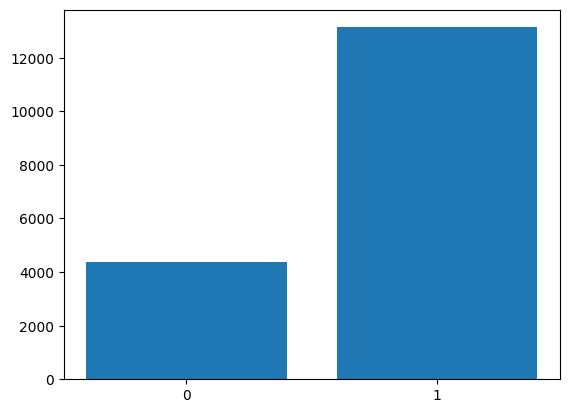

In [ ]:
cactus_is_in_count = train_cactus_df[train_cactus_df["has_cactus"] == 1].shape[0]
cactus_is_not_in_count = 17500 - cactus_is_in_count


plt.bar([0, 1], [cactus_is_not_in_count, cactus_is_in_count])
plt.xticks(np.arange(0, 2, 1))
plt.show()

In [ ]:
base_model = cactus_is_in_count / 17500
print(f"base_model_accuracy : {base_model:.2f}")

base_model_accuracy : 0.75


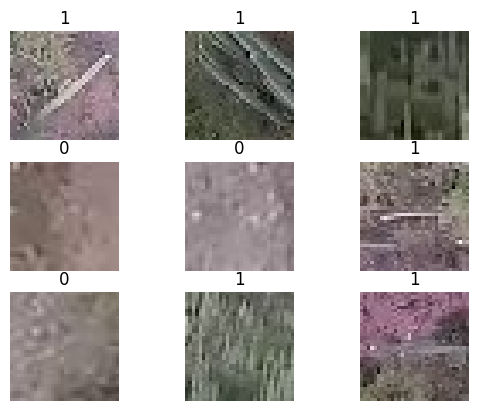

In [ ]:
import pathlib
from tensorflow.keras.utils import load_img

original_dir = pathlib.Path("train")
f, axes = plt.subplots(3, 3)

y, x = 0, 0
for file_name in os.listdir(original_dir):
  file_path = original_dir / file_name
  mini_df = train_cactus_df[train_cactus_df["id"] == file_name]
  axes[y][x].set_title(mini_df.iloc[0, 1])
  axes[y][x].axis('off')
  axes[y][x].imshow(load_img(file_path))
  x += 1
  if x % 3 == 0:
    y += 1
    x = 0
  if y == 3:
    break

2. 모델 선정
- 준비된 이미지의 해상도는 32 * 32 * 3이다
- 우선 얕은 CNN모델을 베이스 라인으로 삼아 만들어본다
- 그 다음 깊은 CNN모델을 구성하여 성능을 향상시키는 방향으로 간다

In [ ]:
import tensorflow as tf
# import random

# seed = 50
# tf.random.set_seed(seed)
# np.random.seed(seed)
# random.seed(seed)
# 시드 설정하는 부분은 잘 모르겠으니 스킵
# tf.random.set_seed(seed)로 global seed 설정 시 seed를 같은 값으로 재설정 할 때마다 시퀀스가 초기화 되고, 매번 같은 시퀀스를 얻는다
# 만약 global seed를 한 번 설정 후 @tf.function으로 함수를 정의해서 각각 연속으로 실행하면 같은 결과가 나오게 된다.
# random 함수 자체에서 설정하는 operational seed에 따라 시퀀스가 갈리게 된다

In [ ]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train_cactus_df,
                                test_size=0.1,
                                stratify=train_cactus_df['has_cactus'],
                                random_state=50)

print(train_df.shape[0])
print(valid_df.shape[0])

15750
1750


In [ ]:
from matplotlib.rcsetup import validate_any
import pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("dataset_dir")
def make_dataset_directory(name):
  for has_cactus in ("0", "1"):
    target_dir = new_base_dir / name / has_cactus
    has_cactus = int(has_cactus)
    try:
      os.makedirs(target_dir)
    except:
      pass
    if name == "train":
      files = train_df[train_df["has_cactus"] == has_cactus]["id"]
    else:
      files = valid_df[valid_df["has_cactus"] == has_cactus]["id"]
    for file in files:
      shutil.copyfile(src=original_dir / file, dst=target_dir / file)


make_dataset_directory("train")
make_dataset_directory("valid")

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (32, 32)
AUTO = tf.data.AUTOTUNE
batch_size = 32

def preprocessing(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
  return image, label

def test_preprocessing(image):
  image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
  return image

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = image_size,
    batch_size = batch_size
).map(preprocessing, num_parallel_calls=AUTO)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "valid",
    image_size = image_size,
    batch_size = batch_size
).map(preprocessing, num_parallel_calls=AUTO)

test_dataset = image_dataset_from_directory(
    "test",
    labels = None,
    label_mode = None,
    image_size = image_size,
    batch_size = batch_size,
    shuffle=False
).map(test_preprocessing, num_parallel_calls=AUTO)

Found 15750 files belonging to 2 classes.
Found 1750 files belonging to 2 classes.
Found 4000 files belonging to 1 classes.


In [ ]:
from tensorflow.python.ops.math_ops import xdivy
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2)]
)

def residual_block(x, depth, filter_size):
  residual = x
  x = layers.Conv2D(depth, filter_size, strides=1, use_bias=False, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(depth, filter_size, strides=1, use_bias=False, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  residual = layers.Conv2D(depth, 1, strides=2)(residual)
  x = layers.add([x, residual])
  x = layers.Activation("relu")(x)
  return x

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(64, 7, strides=2, use_bias=False, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
for depth in [16, 32, 64]:
  x = residual_block(x, depth, 3)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 32, 32, 3)            0         ['input_4[0][0]']             
                                                                                                  
 conv2d_24 (Conv2D)          (None, 16, 16, 64)           9408      ['sequential_3[0][0]']        
                                                                                                  
 batch_normalization_17 (Ba  (None, 16, 16, 64)           256       ['conv2d_24[0][0]']           
 tchNormalization)                                                                          

In [ ]:
import tensorflow as tf


callbacks = [
    tf.keras.callbacks.ModelCheckpoint("cat_vs_dogs_residual_connection.x",
                                       save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
]

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = [tf.keras.metrics.AUC()])

history = model.fit(train_dataset,
                    epochs=20,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/20
493/493 [==============================] - 18s 27ms/step - loss: 0.2134 - auc_2: 0.9612 - val_loss: 0.8681 - val_auc_2: 0.8466 - lr: 0.0010
Epoch 2/20
493/493 [==============================] - 10s 21ms/step - loss: 0.1353 - auc_2: 0.9842 - val_loss: 0.5723 - val_auc_2: 0.9566 - lr: 0.0010
Epoch 3/20
493/493 [==============================] - 10s 21ms/step - loss: 0.1153 - auc_2: 0.9882 - val_loss: 0.1672 - val_auc_2: 0.9774 - lr: 0.0010
Epoch 4/20
493/493 [==============================] - 7s 13ms/step - loss: 0.1024 - auc_2: 0.9906 - val_loss: 0.4721 - val_auc_2: 0.9627 - lr: 0.0010
Epoch 5/20
493/493 [==============================] - 7s 14ms/step - loss: 0.0887 - auc_2: 0.9929 - val_loss: 0.2734 - val_auc_2: 0.9493 - lr: 0.0010
Epoch 6/20
493/493 [==============================] - 6s 13ms/step - loss: 0.0768 - auc_2: 0.9941 - val_loss: 0.3423 - val_auc_2: 0.9740 - lr: 0.0010
Epoch 7/20
493/493 [==============================] - 7s 14ms/step - loss: 0.0727 - auc_2: 0.9947

In [ ]:
best_model = keras.models.load_model("cat_vs_dogs_residual_connection.x")
submission_df["has_cactus"] = best_model.predict(test_dataset)
print(submission_df)
# for image in test_dataset:
#   plt.imshow(image[0])
#   break

125/125 [==============================] - 1s 4ms/step
                                        id  has_cactus
0     000940378805c44108d287872b2f04ce.jpg    0.999999
1     0017242f54ececa4512b4d7937d1e21e.jpg    1.000000
2     001ee6d8564003107853118ab87df407.jpg    0.000202
3     002e175c3c1e060769475f52182583d0.jpg    0.000072
4     0036e44a7e8f7218e9bc7bf8137e4943.jpg    0.999881
...                                    ...         ...
3995  ffaafd0c9f2f0e73172848463bc2e523.jpg    1.000000
3996  ffae37344310a1549162493237d25d3f.jpg    1.000000
3997  ffbd469c56873d064326204aac546e0d.jpg    1.000000
3998  ffcb76b7d47f29ece11c751e5f763f52.jpg    1.000000
3999  fffed17d1a8e0433a934db518d7f532c.jpg    0.999995

[4000 rows x 2 columns]


In [ ]:
submission_df.to_csv("drive/MyDrive/Colab Notebooks/kaggle/cactus/first_submission.csv")

55/55 [==============================] - 1s 10ms/step


424